## opg_after_t02_3_process
计算 t02,t03 结果的 F1, ROC ,以及 AER。

In [279]:
# -*- coding:utf-8 -*-
import datetime
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as scio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as transforms
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import transforms
from torchviz import make_dot
# import hiddenlayer as h
from visdom import Visdom

# from sklearn.preprocessing import label_binarize
# from sklearn import preprocessing
# from sklearn import tree 

sys.path.append("..")
from utils.networks import *
from utils.reuse import *

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda:0


## 预备操作
提前定义好类别数、CNN 原始正确率等指标

In [280]:
num_kn = num_kc = 10
CNN_origin_ACC = 0.8895
GAN_dataarray = np.load("../../data/nina_db1/s1/Fopg_s1_multiset_20220619_vec.npy", allow_pickle=True)
checkpoint_net_fe = torch.load(
    "..//model//opg_testops_220628a//s5//ckp//auc//auc_20kc_781d_ep_183_2022_07_01_00_12_00.pth",
    map_location="cuda:0"
)

## 定义CNN神经网络结构
CNN 训练部分，为了获得一个已知类分类器

In [281]:
# 自定义神经网络,CNN
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

# num_kn = 20

class Network(nn.Module):
    def __init__(self,num_kn = num_kn):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=3, padding=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=3, padding=0
        )

        self.fc1 = nn.Linear(in_features=32 * 10 * 20, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=num_kn)
        self.dr1 = nn.Dropout2d(0.2)

    def forward(self, t):
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        # t = F.max_pool2d(t, kernel_size=2, stride=1)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        # t = self.dr1(t)
        # t = F.max_pool2d(t, kernel_size=2, stride=1)

        # (4) hidden linear layer
        t = t.reshape(-1, 32 * 10 * 20)
        t = self.fc1(t)
        t = F.relu(t)
        t = self.dr1(t)

        # (5) output layer
        t = self.out(t)

        return t


net = Network(num_kn  = num_kn)
# 打印网络，检查输入输出 shape是否正确
# print(net)
summary(net, (1, 20, 10), batch_size=1, device="cpu")
# 可视化结构，torchviz
sampleInput = torch.randn(1, 1, 20, 10).requires_grad_(True)
sampleOutput = net(sampleInput)
print("Outputshape:", sampleOutput.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 20, 10]             320
            Conv2d-2            [1, 32, 20, 10]           9,248
            Linear-3                   [1, 128]         819,328
         Dropout2d-4                   [1, 128]               0
            Linear-5                    [1, 20]           2,580
Total params: 831,476
Trainable params: 831,476
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 3.17
Estimated Total Size (MB): 3.27
----------------------------------------------------------------
Outputshape: torch.Size([1, 20])


## GAN 模型训练

In [282]:
# EMG需要转化成6维特征，用到刚刚训练的模型c_ep_200_acc9763_2022_02_26_23_18_44,
# 并重组为新数据集OpenganDatafea_smr_10cl_220227.npy，步骤见 emgDataprocess.ipynb
# num_kc = 4
# opGAN部分开始
# GAN 模型搭建
# 潜在张量大小,32，4是因为 cnn feature 只有6个，不好比它大
latent_size = 4
# 输出通道数
# n_channel = num_kc
n_channel = 10
# 生成网络隐藏层大小
n_g_feature = 64

gnet = nn.Sequential(
    nn.Flatten(),
    nn.Linear(latent_size, n_g_feature * 1),  # 用线性变换将输入映射到64维
    nn.BatchNorm1d(n_g_feature * 1),
    nn.ReLU(True),  # relu激活
    nn.Dropout2d(0.2),
    nn.Linear(n_g_feature * 1, n_g_feature * 2),  # 线性变换
    nn.BatchNorm1d(n_g_feature * 2),
    nn.ReLU(True),  # relu激活
    nn.Dropout2d(0.2),
    nn.Linear(n_g_feature * 2, n_channel),  # 线性变换
).to(device)
gnet.to("cpu")
# print(gnet)
summary(gnet, (1, 1, 4), batch_size=1, device="cpu")
gnet.to(device)
# 鉴别网络隐藏层大小
# 32,
n_d_feature = 64
dnet = nn.Sequential(
    nn.Flatten(),
    nn.Linear(n_channel, n_d_feature * 2),  # 输入特征数为784，输出为256
    nn.BatchNorm1d(n_d_feature * 2),
    nn.LeakyReLU(0.2),  # 进行非线性映射
    nn.Dropout2d(0.2),
    nn.Linear(n_d_feature * 2, n_d_feature),  # 进行一个线性映射
    nn.BatchNorm1d(n_d_feature),
    nn.LeakyReLU(0.2),
    nn.Dropout2d(0.2),
    nn.Linear(n_d_feature, 1),
    # nn.Sigmoid()  # 也是一个激活函数，二分类问题中，
    # sigmoid可以班实数映射到【0,1】，作为概率值，
    # 多分类用softmax函数
).to(device)
# print(dnet)
dnet.to("cpu")
summary(dnet, (1, 1, num_kc), batch_size=1, device="cpu")
dnet.to(device)
# 初始化权重
def weights_init(m):
    if type(m) in [nn.ConvTranspose2d, nn.Conv2d]:
        init.xavier_normal_(m.weight)
    elif type(m) == nn.BatchNorm2d:
        init.normal_(m.weight, 1.0, 0.02)
        init.constant_(m.bias, 0)


gnet.apply(weights_init)
dnet.apply(weights_init)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                     [1, 4]               0
            Linear-2                    [1, 64]             320
       BatchNorm1d-3                    [1, 64]             128
              ReLU-4                    [1, 64]               0
         Dropout2d-5                    [1, 64]               0
            Linear-6                   [1, 128]           8,320
       BatchNorm1d-7                   [1, 128]             256
              ReLU-8                   [1, 128]               0
         Dropout2d-9                   [1, 128]               0
           Linear-10                    [1, 20]           2,580
Total params: 11,604
Trainable params: 11,604
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.04
Estimated Tot

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=20, out_features=128, bias=True)
  (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Dropout2d(p=0.2, inplace=False)
  (5): Linear(in_features=128, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Dropout2d(p=0.2, inplace=False)
  (9): Linear(in_features=64, out_features=1, bias=True)
)

### GAN 数据加载，构建数据集

In [283]:
# 加载 openGAN 所需数据，这里只有训练、验证两部分，没有测试集，因为本次数据采集划分时只划出两部分，不影响最终结果
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # 将图片转换为Tensor,归一化至[0,1]
    ]
)
# GAN_dataarray = np.load("../../data/nina_db1/t03/s1/Fopg_s1_diff_ratio_vec_20220629.npy", allow_pickle=True)
GANdataset = GAN_dataarray.item()
print(type(GANdataset))

ktr_str_X = "vec_ktr_X_"+str(num_kc)+"c"
ktr_str_Y = "ktr_Y_"+str(num_kc)+"c"
val_str_X = "vec_val_X_"+str(num_kc)+"c"
val_str_Y = "val_Y_"+str(num_kc)+"c"
dte_str_X = "vec_dte_X_"+str(num_kc)+"c"
dte_str_Y = "dte_Y_"+str(num_kc)+"c"

traindata = GANdataset[ktr_str_X]
trainlabel = GANdataset[ktr_str_Y]
# 本方法中的 test 实际上是个大号的完整版openset,所以标签是01
testdata = GANdataset[dte_str_X]
testlabel = GANdataset[dte_str_Y]
testlabel_for_auc = GANdataset[dte_str_Y]
testlabel_for_auc = testlabel_for_auc.ravel()

valdata = GANdataset[val_str_X]
vallabel = GANdataset[val_str_Y]
vallabel_for_auc = GANdataset[val_str_Y]
vallabel_for_auc = vallabel_for_auc.ravel()

# 注意这里 ktr，kte 的标签需要降维，其他的在数据制作阶段已经降过了
# trainlabel = trainlabel[:, 0]
# testlabel = testlabel[:,0]
# vallabel = vallabel[:, 0]
# trainunknownc_label = trainunknownc_label[:,0]
# print(type(trainlabel))
train_set = EMGDataset_1D(traindata, trainlabel)
test_set = EMGDataset_1D(testdata, testlabel)
val_set = EMGDataset_1D(valdata, vallabel)
# train_unknown = EMGDataset(trainunknown_data,trainunknownc_label)
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, pin_memory=True,
#                                             num_workers=3)

sample = next(iter(train_set))
print(sample)
sample = next(iter(test_set))
print(sample)
sample = next(iter(val_set))
print(sample)

<class 'dict'>
(tensor([ 10.3302,  -2.5475,   3.2432,   7.4799,  -3.1612,   1.5022, -11.6617,
        -11.8620,  -9.0678,  -4.9403, -39.4637, -16.6913,  -2.7139,  -0.4689,
         -3.9056,  -8.0087,  -9.9941, -11.1451,   1.5352,  -0.5800]), array([0], dtype=int16))
(tensor([  9.3868,  -1.5282,   3.4865,   6.5483,  -2.9376,   1.4634,  -9.3474,
         -9.0537,  -7.9205,  -3.4728, -39.7663, -17.9818,  -3.3958,  -0.2415,
         -3.7067,  -8.3086,  -8.9139, -11.3046,   0.5570,  -1.2551]), array([1], dtype=int16))
(tensor([ 33.2800, -56.2091, -24.8004, -43.1061, -29.1541, -53.0438, -20.4819,
          5.2978, -38.5836,   6.9705, -41.1139,   8.0074, -49.0252,  -9.9886,
        -30.3435, -14.8888, -20.3850, -38.7737, -39.4788, -39.8713]), array([1], dtype=int16))


### 训练 GAN

## 验证结果
绘制 ROC 曲线

F1:  0.69492 
CLose ACC/AER: 
  0.8895 /  0.1105  
 Open Orgin ACC/AER: 
  0.30614 /  0.69386  
 Open GAN ACC/AER: 
  0.72407 /  0.27593 


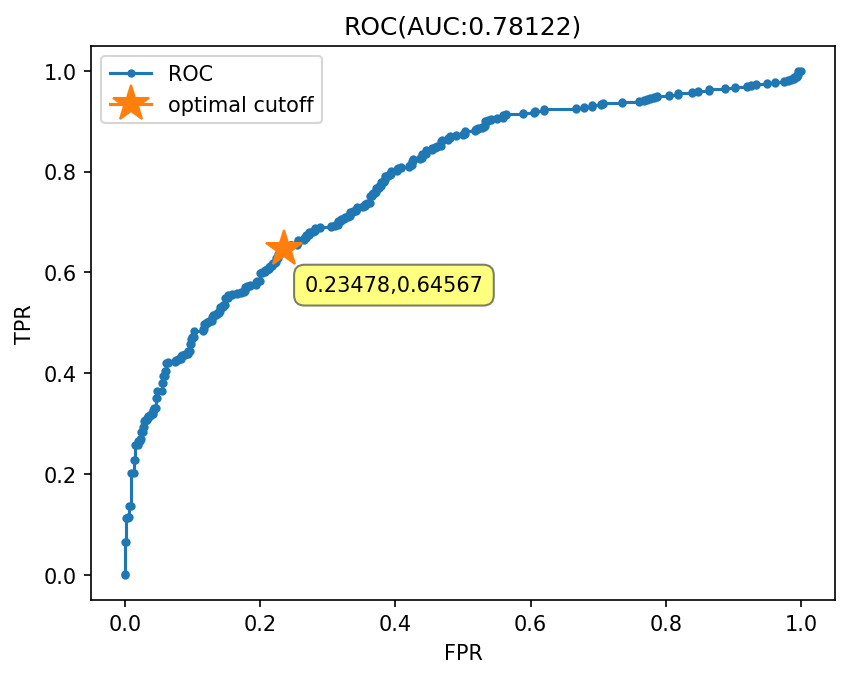

In [284]:
# CNN_origin_ACC = 0.9605
# 加载挑出的模型，计算 ROC 曲线、最佳阈值及 AUC 值
# checkpoint_net_fe = torch.load(
#     "..//model//opg_testops_220628a//s1//ckp//auc//auc868d_ep_2473_2022_06_29_22_37_11.pth",
#     map_location="cuda:0"

# )
# net_fe = GAN_Dis_opengan_alpha(n_channel, n_d_feature)
net_fe = dnet
net_fe.to("cpu")
net_fe.load_state_dict(checkpoint_net_fe["model"])
net_fe.eval()
# 计算模型对数据集的预测值，此函数还会通过sigmod函数以保持输出在0-1内
emg_vec = emgdata_to_net_preds_sigmoid(data_set=val_set, net_vector=dnet)
# 用来计算ROC,AUC 的数据需要同格式，直接全部展平至一维
emg_vec = emg_vec.ravel()
vallabel_for_auc = vallabel_for_auc.ravel()
auc_test = metrics.roc_auc_score(vallabel_for_auc, emg_vec, average="micro")
# 计算roc曲线，以备后续绘制
fpr, tpr, thresholds = metrics.roc_curve(vallabel_for_auc, emg_vec)
auc_test_r = metrics.auc(fpr, tpr)
# 按约登指数计算最佳阈值点
optimals, points = Find_Optimal_Cutoff(tpr, fpr, thresholds)
# 作ROC图
plt.rcParams["figure.dpi"] = 150
plt.title("ROC(AUC:" + str("%.5g" % auc_test_r) + ")")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(fpr, tpr, marker=".", label="ROC")
plt.plot(points[0], points[1], marker="*", markersize=18, label="optimal cutoff")
# 在 ROC 图上标注最佳阈值点
plt.annotate(
    str("%.5g" % points[0]) + "," + str("%.5g" % points[1]),
    xy=(points[0], points[1]),
    xytext=(10, -20),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.5", fc="yellow", ec="k", lw=1, alpha=0.5),
)
# 显示图例
plt.legend()
# plt.show()
# 计算 f1-score，看起来f1score需要把预测值变成预测标签才行
# emg_vec_preds = emg_vec
emg_vec_preds = np.zeros(np.size(emg_vec))
a_idx_emgvec = emg_vec>= optimals
emg_vec_preds[a_idx_emgvec] = 1
a_f1_score = metrics.f1_score(vallabel_for_auc, emg_vec_preds, average="binary")
print("F1:",'\033[33m',str("%.5g" % a_f1_score),'\033[0m')

P_label = vallabel_for_auc == 1
val_set_P = len(vallabel_for_auc[P_label])
val_set_N = len(vallabel)
val_set_TPR = points[1]
val_set_TNR = 1-val_set_TPR
val_set_FPR = points[0]
val_set_FNR = 1-val_set_FPR
val_set_ACC = (val_set_TPR *val_set_P+val_set_FNR*val_set_N)/(val_set_P+val_set_N)
val_set_AER = 1-val_set_ACC
# CNN_origin_ACC = 0.9605
CNN_no_rejection_ACC = CNN_origin_ACC *val_set_P/(val_set_P+val_set_N)

print(
    "CLose ACC/AER:","\n",'\033[32m',
    str("%.5g" % CNN_origin_ACC),"/",'\033[31m',str("%.5g" % (1-CNN_origin_ACC)),'\033[0m',
    "\n",
    "Open Orgin ACC/AER:","\n",'\033[32m',
    str("%.5g" % CNN_no_rejection_ACC), "/",'\033[31m',
    str("%.5g" % (1-CNN_no_rejection_ACC)),'\033[0m',
    "\n",
    "Open GAN ACC/AER:","\n",'\033[32m',
    str("%.5g" % val_set_ACC),"/",'\033[31m',
    str("%.5g" % val_set_AER),'\033[0m',
)
plt.show()